In [1]:
# License: BSD
#  How do we acknowledge Author: Sasank Chilamkurthy 

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '.'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

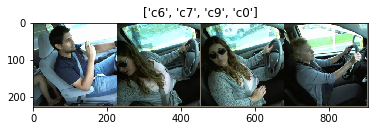

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Define the neural network used
model_ft = models.alexnet(pretrained =True)


In [5]:
net = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )
model_ft.classifier = net

In [6]:
# Freeze all layers except for the final fully connected layer.
for param in model_ft.parameters():
    param.requires_grad = False

#model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

In [7]:
# Replace the final layer to classify into one of 10 classes.
net2 = nn.Linear(4096, 10)
model_ft.classifier.add_module('classify',net2)

In [8]:
if torch.cuda.is_available():
    model_ft = model_ft.cuda()
    print ("Transfer model to GPU")

Transfer model to GPU


In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
optimizer = optim.SGD(model_ft.classifier.classify.parameters(),lr=0.001, momentum=0.9)
# Can add other args such as weight decay etc.

In [11]:
import math

In [12]:
T = 10 # Number of epochs
batch_size = 4
NB = math.ceil(len(image_datasets['train']) /batch_size) 
NB = int(NB)
print (NB)

5006


In [13]:
import torch.autograd as ag

In [14]:
import time

In [15]:
# Start the training process.
for epoch in range(5):
    
    running_loss = 0.0
    # Set model to training mode
    model_ft.train()
    t0 = time.time()   
    for i,(inputs,classes) in enumerate(dataloaders['train'],0):
        
        # Obtain a batch of training data
        inputs = inputs.cuda()
        classes = classes.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        inputs = ag.Variable(inputs,requires_grad=True)
        classes = ag.Variable(classes, requires_grad =False)
        outputs = model_ft(inputs)
        
        # Error evaluation
        loss = criterion(outputs,classes)
        
        # Back Propagation
        loss.backward()
        
        # Parameter update
        optimizer.step()
        
        # Print averaged loss per minibatch every 1000 mini-batches
        running_loss += loss[0]
        if i%1000 == 999:
            print ('[%d, %5d] loss: %.3f'% (epoch+1, i+1,np.mean(running_loss.cpu().data.numpy())/1000))
            running_loss = 0.0
    print('{} seconds'.format(time.time() - t0))
print ("Finished Training")
    
    

[1,  1000] loss: 2.176
[1,  2000] loss: 1.706
[1,  3000] loss: 1.543
[1,  4000] loss: 1.494
[1,  5000] loss: 1.427
53.8374278545 seconds
[2,  1000] loss: 1.379
[2,  2000] loss: 1.330
[2,  3000] loss: 1.348
[2,  4000] loss: 1.335
[2,  5000] loss: 1.289
72.5134499073 seconds
[3,  1000] loss: 1.306
[3,  2000] loss: 1.263
[3,  3000] loss: 1.283
[3,  4000] loss: 1.268
[3,  5000] loss: 1.269
71.7293028831 seconds
[4,  1000] loss: 1.295
[4,  2000] loss: 1.300
[4,  3000] loss: 1.263
[4,  4000] loss: 1.240
[4,  5000] loss: 1.292
71.9999678135 seconds
[5,  1000] loss: 1.237
[5,  2000] loss: 1.265
[5,  3000] loss: 1.317
[5,  4000] loss: 1.251
[5,  5000] loss: 1.308
73.3528940678 seconds
Finished Training


In [16]:
correct = 0
# Run trained model on test data
for i,(inputs,classes) in enumerate(dataloaders['val'],0):
    inputs = inputs.cuda()
    classes = classes.cuda()
    inputs = ag.Variable(inputs,requires_grad=True)
    classes = ag.Variable(classes, requires_grad =False)
    outputs = model_ft(inputs)
    
    # Calculate Accuracy
    outputs_np = outputs.cpu().data.numpy().T.argmax(axis=0)
    classes_np = classes.cpu().data.numpy()
    
    correct += np.mean(np.equal(classes_np,outputs_np))
print (correct/len(dataloaders['val'])*100)   

62.701053799223516
